# Pub accessibility for Inner London

`matplotlib` magic command (only necessary for `jupyter` notebooks). 

Install and update `cityseer` if necessary.

In [1]:
# !pip install --upgrade cityseer

## Data and preparation

> Pubs (data provided by CAMRA in January 2019)
> https://data.london.gov.uk/download/cultural-infrastructure-map/7e6b0f36-da01-4029-99d7-640d89c4a0a4/Pubs.csv
> Buildings defined by CAMRA as pubs. Licensed premises must be open to and welcome the general public without requiring membership or residency, allow free entry (1), serve at least one draught beer (2), allow drinking without requiring food to be consumed, have at least one indoor area not laid out for meals, and permit drinks to be purchased in person at a bar (3), without relying on table service.’ (1) Except when entertainment is provided on limited occasions (2) Includes cask or keg beer (3) Includes also a hatch or specific service point’
> How data was compiled: Data provided by the Campaign for Real Ale.
> Credit for use: The Campaign for Real Ale

This examples calculates landuse accessibility to pubs for inner London.

For additional information on network preparation, see the corresponding notebook on [graph cleaning](https://colab.research.google.com/github/cityseer/cityseer/blob/master/demos/graph_cleaning.ipynb).

This example will make use of OSM data downloaded from the [OSM API](https://wiki.openstreetmap.org/wiki/API) for a 5000m radius around London Soho.

In [2]:
# prepare network from OSM
from cityseer.tools import graphs, mock

# starting point
lng, lat = -0.13396079424572427, 51.51371088849723
distance = 5000
# download from OSM - see docs if you want examples for how to use osmNx for this step
G_utm = mock.make_buffered_osm_graph(lng, lat, distance)
# simplify - this is not necessary if using "clean" graph sources - e.g. OS Open Roads
G = graphs.nx_simple_geoms(G_utm)
G = graphs.nx_remove_filler_nodes(G)
G = graphs.nx_remove_dangling_nodes(G, despine=20, remove_disconnected=True)
G = graphs.nx_remove_filler_nodes(G)
G1 = graphs.nx_consolidate_nodes(G, buffer_dist=10, min_node_group=3)
G2 = graphs.nx_split_opposing_geoms(G1, buffer_dist=15)
G3 = graphs.nx_consolidate_nodes(G2, buffer_dist=15, crawl=False, min_node_degree=2, cent_min_degree=4)
# decompose for higher resolution analysis
G_decomp = graphs.nx_decompose(G3, 25)

/Users/gareth/dev/benchmark-urbanism/cityseer-api/__pypackages__/3.9/lib/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
INFO:cityseer.tools.mock:UTM conversion info: UTM zone number: 30, UTM zone letter: U
INFO:cityseer.tools.graphs:Converting networkX graph from WGS to UTM.
INFO:cityseer.tools.graphs:Processing node x, y coordinates.
100%|██████████| 142772/142772 [00:23<00:00, 5991.17it/s]
INFO:cityseer.tools.graphs:UTM conversion info: UTM zone number: 30, UTM zone letter: U
INFO:cityseer.tools.graphs:Processing edge geom coordinates, if present.
100%|██████████| 160524/160524 [00:00<00:00, 349247.03it/s]
INFO:cityseer.tools.graphs:Generating simple (straight) edge geometries.
100%|██████████| 160524/160524 [00:04<00:00, 37340.80it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 142772

<Figure size 432x288 with 0 Axes>

In [3]:
# prepare data layer
import pandas as pd
import geopandas as gpd
import numpy as np
from cityseer.metrics import layers

# prepare network data structures for cityseer
nodes_gdf, network_structure = graphs.network_structure_from_nx(G_decomp, crs=32630)  # UTM zone 30N
# load data from URL
pubs_data_io = pd.read_csv(
    "https://data.london.gov.uk/download/cultural-infrastructure-map/7e6b0f36-da01-4029-99d7-640d89c4a0a4/Pubs.csv"
)
pubs_data_gdf = gpd.GeoDataFrame(
    pubs_data_io, crs=27700, geometry=gpd.points_from_xy(pubs_data_io.easting, pubs_data_io.northing)
)
# convert to the same UTM CRS as the network
pubs_data_gdf = pubs_data_gdf.to_crs(32630)  # to match EPSG code for UTM zone 30N per network data
# all pubs will have the same landuse category
pubs_data_gdf["landuse_category"] = "pub"
pubs_data_gdf.head()
# compute pub accessibility
nodes_gdf, pubs_data_gdf = layers.compute_accessibilities(
    pubs_data_gdf,
    landuse_column_label="landuse_category",
    accessibility_keys=["pub"],
    nodes_gdf=nodes_gdf,
    network_structure=network_structure,
    distances=[100, 200, 400, 800],
)

INFO:cityseer.tools.graphs:Preparing node and edge arrays from networkX graph.
100%|██████████| 90378/90378 [00:23<00:00, 3869.01it/s]


  0%|          | 0.0/4098 [00:06<?, ?it/s]

/Users/gareth/dev/benchmark-urbanism/cityseer-api/cityseer/algos/data.py:126: NumbaWarning: Cannot cache compiled function "assign_to_network" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @njit(cache=True, fastmath=config.FASTMATH, nogil=True, parallel=True)


100%|██████████| 4098.0/4098 [00:07<00:00, 552.61it/s] 

INFO:cityseer.metrics.layers:Computing land-use accessibility for: pub



  0%|          | 0.0/90378 [00:09<?, ?it/s]

/Users/gareth/dev/benchmark-urbanism/cityseer-api/cityseer/algos/data.py:468: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  reachable_data, reachable_data_dist = aggregate_to_src_idx(


100%|██████████| 90378.0/90378 [01:06<00:00, 1366.77it/s]



    Distance weighted Pub accessibility:
    Avg walking tolerance: 35.12m
    Beta: 0.03999999910593033 (spatial impedance factor)
    Max walking tolerance: 100m
    


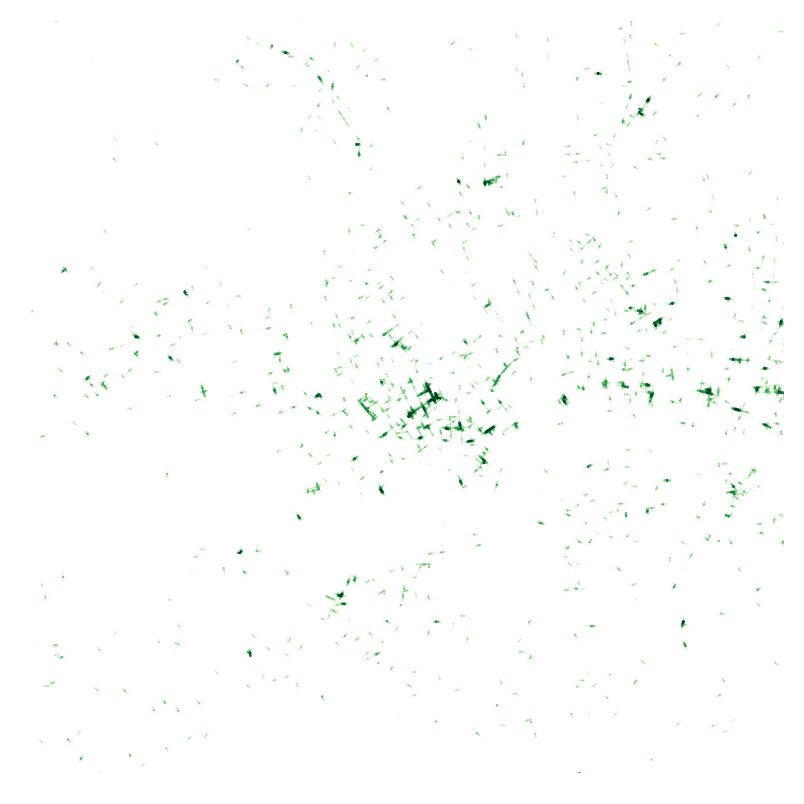


    Distance weighted Pub accessibility:
    Avg walking tolerance: 70.24m
    Beta: 0.019999999552965164 (spatial impedance factor)
    Max walking tolerance: 200m
    


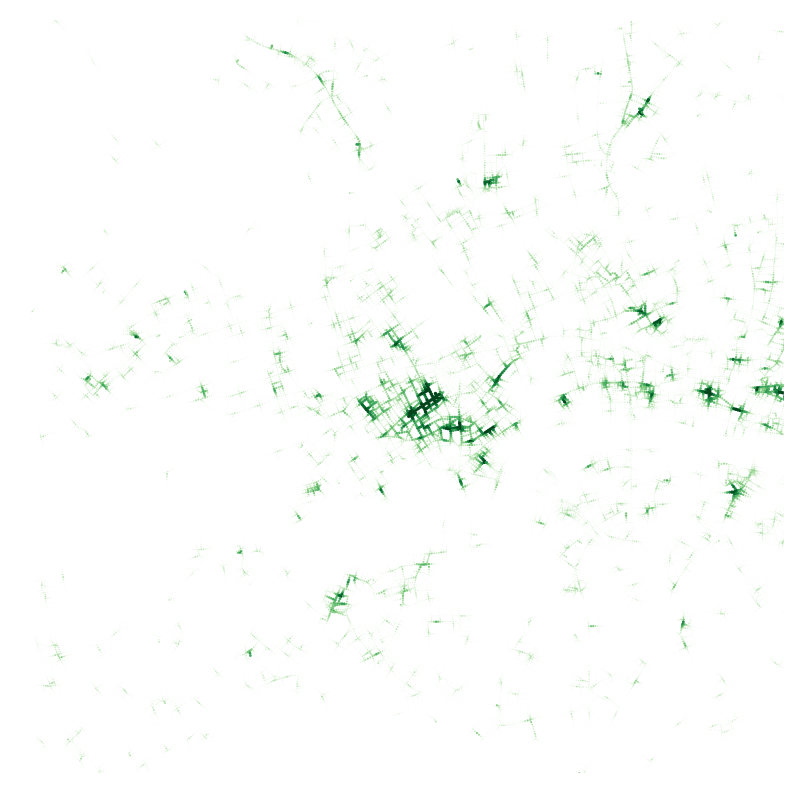


    Distance weighted Pub accessibility:
    Avg walking tolerance: 140.48m
    Beta: 0.009999999776482582 (spatial impedance factor)
    Max walking tolerance: 400m
    


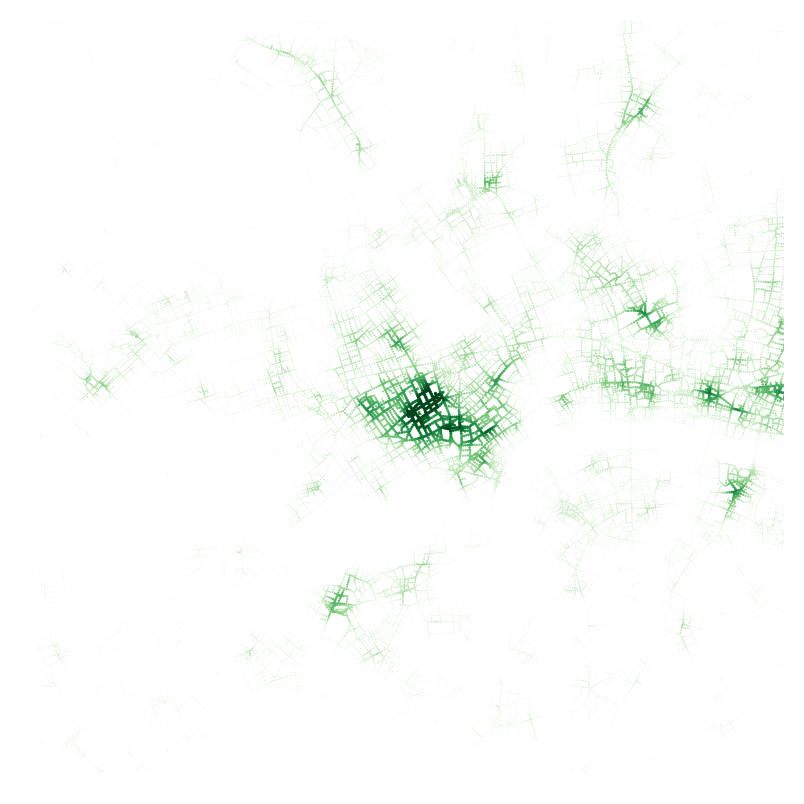


    Distance weighted Pub accessibility:
    Avg walking tolerance: 280.96m
    Beta: 0.004999999888241291 (spatial impedance factor)
    Max walking tolerance: 800m
    


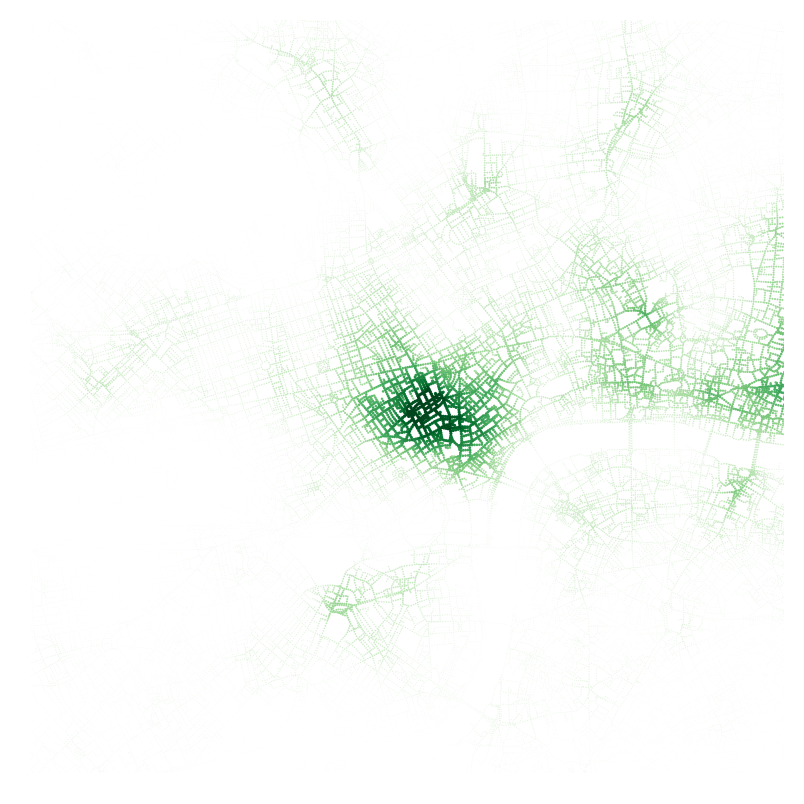

In [4]:
# data can be extracted, plotted, or otherwise manipulated directly from the numpy arrays
# see the getting started guide if you'd prefer to first convert back to NetworkX
from cityseer.metrics import networks

import utm
from shapely import geometry
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import minmax_scale


def simple_plot(xs: np.ndarray, ys: np.ndarray, vals: np.ndarray):
    """ """
    # extents
    easting, northing = utm.from_latlon(lat, lng)[:2]
    buff = geometry.Point(easting, northing).buffer(3500)
    min_x, min_y, max_x, max_y = buff.bounds
    # fig
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, facecolor="white")
    # filter
    select = xs > min_x
    select = np.logical_and(select, xs < max_x)
    select = np.logical_and(select, ys > min_y)
    select = np.logical_and(select, ys < max_y)
    select_idx = np.where(select)[0]
    # remove any extreme outliers
    v = np.clip(vals, np.nanpercentile(vals, 0.01), np.nanpercentile(vals, 99.9))
    # shape if wanted
    c = v**1
    c = minmax_scale(c, feature_range=(0, 1))
    s = v**1
    s = minmax_scale(s, feature_range=(0, 1.5))
    # plot
    ax.scatter(
        xs[select_idx], ys[select_idx], c=c[select_idx], s=s[select_idx], linewidths=0, edgecolors="none", cmap="Greens"
    )
    # limits
    ax.set_xlim(left=min_x, right=max_x)
    ax.set_ylim(bottom=min_y, top=max_y)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect(1)
    ax.set_facecolor("white")
    plt.show()


for d in [100, 200, 400, 800]:
    b = networks.beta_from_distance(d)[0]
    avg_d = networks.avg_distance_for_beta(float(b))[0]
    print(
        f"""
    Distance weighted Pub accessibility:
    Avg walking tolerance: {avg_d:.2f}m
    Beta: {b} (spatial impedance factor)
    Max walking tolerance: {d}m
    """
    )
    simple_plot(network_structure.nodes.xs, network_structure.nodes.ys, nodes_gdf[f"cc_metric_pub_{d}_weighted"])